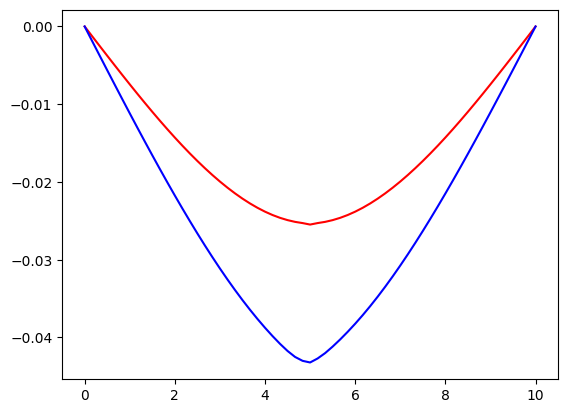

In [21]:
'''
The purpose of this script is to use the XFEMBeam.py class to create the example problem outlined in 4.C.1 of my thesis.

Synopsis: To illustrate the XFEM dataset generation process, an example problem is created using a two-dimensional plane-stress model of a beam structure. Both a damaged and undamaged structure will be modeled and the loading conditions will be identical. To convince readers of the usefulness the displacement field will be taken from the top surface while the damage will be inserted in the bottom of the structure. The training data used will mimic this procedure.
'''

import numpy as np
import matplotlib.pyplot as plt
import XFEMBeam as XBEM

# Beam Parameters
length = 10
height = 1
thickness = 0.1
num_elements_x = 60
num_elements_y = 20
E = 10e+7
G = 3.8e+6
PR = 0.33

data = []

# Crack Definition
crackStartX = 5.0
crackStartY = 0.0
crackEndX = 5.0
crackEndY = 0.5

# Load Definition
P = 1000  # Magnitude of applied load [N]
load = np.array([0, -P])
loadX = 5.0
loadY = 1.0
loadLocation = np.array([loadX, loadY])

# Initialize both models and generate mesh
undamagedBeam = XBEM.XFEMCantileverBeam(length, height, thickness, num_elements_x,
                                  num_elements_y, E, G, PR)
damagedBeam = XBEM.XFEMCantileverBeam(length, height, thickness, num_elements_x,
                                  num_elements_y, E, G, PR)
undamagedBeam.generate_mesh()
damagedBeam.generate_mesh()

# Define crack geometry and impose it on the damaged model
crackStart = (crackStartX, crackStartY)
crackEnd =  (crackEndX, crackEndY)
damagedBeam.add_surface_crack(crackStart, crackEnd)
damagedBeam.add_enrichment()

# Assembly and boundary conditions
undamagedBeam.assemble_global_stiffness()
damagedBeam.assemble_global_stiffness()
undamagedBeam.apply_boundary_conditions("simply")
damagedBeam.apply_boundary_conditions("simply")

# Apply load (current implementation doesn't apply loads to our boundary conditions so this is OKAY, not the best way of doing things...)
undamagedBeam.apply_concentrated_load(load, loadLocation)
damagedBeam.apply_concentrated_load(load, loadLocation)

# Solve static systems
undamagedU = undamagedBeam.solve_static_system()
damagedU = damagedBeam.solve_static_system()

# Extract displacements
numNodes = len(undamagedBeam.nodes)
undamagedStandardU = undamagedU[:2 * numNodes]  # Extract first 2*num_nodes entries
undamagedStandardU = undamagedStandardU.reshape((numNodes, 2))
damagedStandardU = damagedU[:2 * numNodes]
damagedStandardU = damagedStandardU.reshape((numNodes, 2))

# Identify nodes for extraction (in this case the top surface, where y co-ordinate == 1 in original mesh)
undamagedTopNodes = np.where(undamagedBeam.nodes[:, 1] == 1)[0]  # Nodes where y == 1
undamagedTopDisplacements = undamagedStandardU[undamagedTopNodes, 1]  # Extract vertical displacements
damagedTopNodes = np.where(damagedBeam.nodes[:, 1] == 1)[0]
damagedTopDisplacements = damagedStandardU[damagedTopNodes, 1]

# Storing Results
xCoords = np.linspace(0, length, np.size(undamagedTopDisplacements))

# exporting them to make interactive figure that's good for thesis in regular .py script
data = np.array([xCoords, undamagedTopDisplacements, damagedTopDisplacements])

np.savetxt("ExampleResults.csv", data, delimiter=",")
# Quick visualization to make sure results are as expected.
plt.plot(xCoords, undamagedTopDisplacements, "r")
plt.plot(xCoords, damagedTopDisplacements, "b")
# This shows that it works, now to